In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import json, time, os, sys, glob
import shutil
import warnings
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
import subprocess
from tqdm import tqdm
from omegaconf import OmegaConf
import pytorch_lightning as pl
from terrace.batch import DataLoader
from typing import Sequence
import matplotlib.pyplot as plt

from fireprot_dataset import *
from training.model_utils import featurize, loss_smoothed, loss_nll, get_std_opt, ProteinMPNN
from training.utils import worker_init_fn, get_pdbs, loader_pdb, build_training_clusters, PDB_dataset, StructureDataset, StructureLoader
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN
from kaggle_dataset import KaggleTrainDataset
from transfer_model import *
from train import *
from combo_dataset import *
from all_dataset_metrics import *

In [4]:
df = df = pd.read_csv("data/v2_monomers_allmutations_oldAlignment_wmetadata_bestpH.csv")

In [10]:
cfg = OmegaConf.load("config.yaml")
cfg = OmegaConf.merge(cfg, OmegaConf.load("local.yaml"))

In [16]:
dataset = FireProtDataset(cfg, "val")
model = get_old_model_by_name(cfg, "rocklin_ml")
model = model.eval()

Skipping val 1YU5
Skipping val 1MJC
Skipping test 1UBQ


/home/boris/miniconda3/envs/chem/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [24]:
errors = []
with torch.no_grad():
    for mut_pdb, mutations in tqdm(dataset):
        size = len(mut_pdb[0]["seq"])
        pred, _ = model(mut_pdb, mutations)
        for mut, out in zip(mutations, pred):
            if mut.ddG is not None:
                errors.append((size, F.mse_loss(mut.ddG, out["ddG"])))

100%|██████████| 80/80 [00:24<00:00,  3.32it/s]


In [32]:
size = [ error[0] for error in errors ]
mse = [ error[1].item() for error in errors ]
rms = [ torch.sqrt(error[1]).item() for error in errors ]

In [ ]:
size_rm

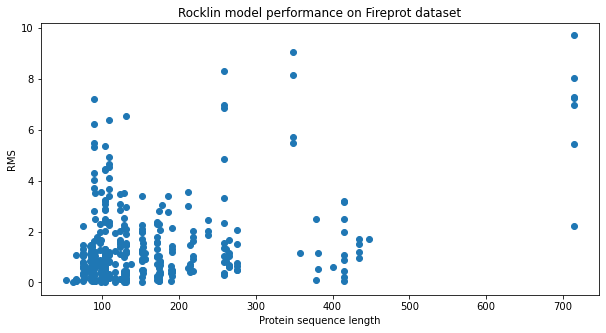

In [38]:
plt.scatter(size, rms)
plt.xlabel("Protein sequence length")
plt.ylabel("RMS")
plt.title("Rocklin model performance on Fireprot dataset")
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.savefig("data/size_rms.png")